In [1]:
using Printf, DelimitedFiles
using Plots
using DataFrames
using Revise, MDToolbox

In [2]:
#using BSON: @save, @load
#@load "df.bson" df

In [3]:
using JLD2

df = load("df.jld2")["df"]

,fnames,score,omega,phi,prou
,Any,Any,Any,Any,Any
1,1/complex.1.pdb,1024.65,"[-0.0281216, 0.968563, 0.247175]",142.637,"[-8.75967, 5.99937, -24.5054]"
2,1/complex.2.pdb,995.933,"[0.574083, -0.500062, -0.648356]",147.139,"[-14.8289, 9.28651, -20.2926]"
3,1/complex.3.pdb,975.648,"[0.586679, -0.575964, -0.569274]",159.814,"[-12.8229, 8.26763, -21.5797]"
4,1/complex.4.pdb,962.002,"[-0.135677, -0.937363, 0.320845]",150.089,"[-11.0709, -7.65869, -27.0568]"
5,1/complex.5.pdb,915.738,"[-0.588624, 0.61065, 0.529744]",163.212,"[-12.2797, 7.92458, -22.7795]"
6,1/complex.6.pdb,909.798,"[0.0512852, 0.569022, -0.820722]",93.3045,"[-11.8917, -23.1444, -16.7896]"
7,1/complex.7.pdb,874.365,"[0.235571, -0.971857, -0.000318399]",151.007,"[-15.8386, -3.83192, -22.0794]"
8,1/complex.8.pdb,872.42,"[-0.855621, 0.514046, -0.0605748]",174.23,"[-5.56816, -11.4507, -18.5221]"
9,1/complex.9.pdb,868.374,"[-0.778727, 0.603605, 0.17101]",43.4144,"[20.4586, 30.4552, -14.334]"


In [4]:
sort!(df, [:score], rev=true);
#dfs = vcat(df, df)
#sort!(dfs, [:score], rev=true)

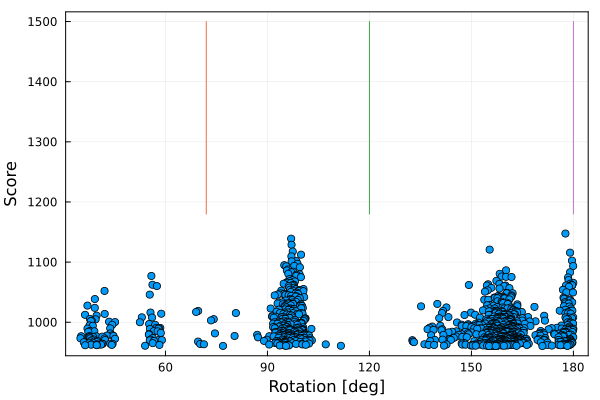

In [5]:
#pyplot()
plot(df.phi[1:1000], df.score[1:1000], seriestype=:scatter, dpi=250, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Score")
#s = collect(970:1350)
s = collect(1180:1500)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

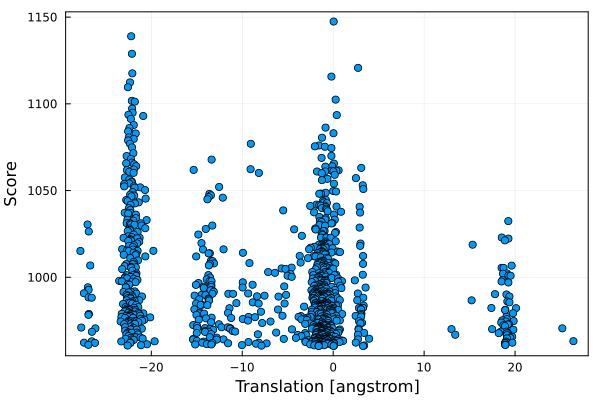

In [6]:
#pyplot()
plot(df.d[1:1000], df.score[1:1000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Translation [angstrom]"); yaxis!("Score")

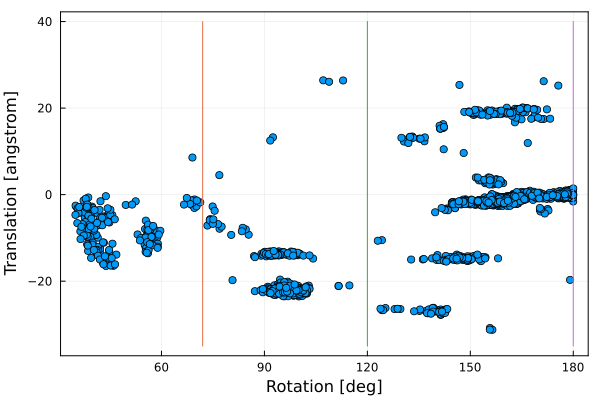

In [7]:
#pyplot()
plot(df.phi[1:2000], df.d[1:2000], seriestype=:scatter, dpi=150, label=nothing, box_style=:box)
xaxis!("Rotation [deg]"); yaxis!("Translation [angstrom]")
s = collect(-35:40)
plot!(fill(360/5, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/3, length(s)), s, label=nothing, dpi=250)
plot!(fill(360/2, length(s)), s, label=nothing, dpi=150)

In [8]:
function create_heatmap(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 190, nx+1)
    edge_y = range(minimum(y), maximum(y), ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = maximum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1])) .+ (edge_x[2] - edge_x[1])
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1])) .+ (edge_y[2] - edge_y[1])    
    return (z=A, x=grid_x, y=grid_y)
end

create_heatmap (generic function with 1 method)

In [ ]:
n = 100000
F = create_heatmap(df.phi[1:n], df.d[1:n], df.score[1:n], 50, 100)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:viridis,  
     st=:contourf, levels=range(minimum(F.z[F.z .> -Inf]), maximum(F.z), 10))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

In [ ]:
savefig(p, "heatmap_score.png")

In [ ]:
function create_heatmap_min(x, y, z, nx, ny)
    A = zeros(Float64, ny, nx)
    A .= -Inf64
    #edge_x = range(minimum(x), maximum(x), nx+1)
    edge_x = range(20, 190, nx+1)
    edge_y = range(minimum(y), maximum(y), ny+1)
    for ix in 1:nx
        for iy in 1:ny
            id_x = edge_x[ix] .<= x .< edge_x[ix+1]
            id_y = edge_y[iy] .<= y .< edge_y[iy+1]
            id = id_x .& id_y
            if !isempty(z[id])
                A[iy, ix] = minimum(z[id])
            end
        end
    end
    grid_x = edge_x[1:end-1] .+ (0.5 * (edge_x[2] - edge_x[1])) .+ (edge_x[2] - edge_x[1])
    grid_y = edge_y[1:end-1] .+ (0.5 * (edge_y[2] - edge_y[1])) .+ (edge_y[2] - edge_y[1])    
    return (z=A, x=grid_x, y=grid_y)
end

In [ ]:
using Combinatorics

function compute_rmsd_permute(ref, t, nmer)
    natom = Int(t.natom / nmer)
    nmer_ref = Int(ref.natom / natom)
    index_pairs = collect(permutations(1:nmer_ref, nmer))
    rmsd = Inf64
    for index in index_pairs
        id = Vector{Int}(undef, 0)
        for imer = 1:nmer
            id = [id; (natom*(index[imer]-1)+1):(natom * index[imer])]
        end
        ref2 = ref[:, id]
        t2 = superimpose(ref2, t)
        r = compute_rmsd(ref2, t2)
        if r[1] < rmsd
            rmsd = r[1]
        end
    end
    return rmsd
end

In [ ]:
t = mdload("ref.pdb")
t = t["atomname CA"]
ref = t[1, :]
for imer = 2:2
    ref = hcat(ref, t[imer, :])
end
ref

In [ ]:
function read_ascii(fname)
    lines = readlines(fname)
    natom = length(lines)
    xyz = zeros(Float64, 1, natom*3)
    for i = 1:natom
        xyz[1, 3*(i-1)+1] = parse(Float64, lines[i][31:38])
        xyz[1, 3*(i-1)+2] = parse(Float64, lines[i][39:46])
        xyz[1, 3*(i-1)+3] = parse(Float64, lines[i][47:54])
    end
    TrjArray(xyz=xyz)
end

In [19]:
ntop = 10000
rmsd = zeros(Float64, ntop)
t = mdload("1/complex.1.pdb")
id = select_atom(t, "atomname CA")

for i in 1:ntop
    filename = df.fnames[i]
    t = read_ascii(filename)
    t_ca = t[:, id]
    rmsd[i] = compute_rmsd_permute(ref, t_ca, 2)
end

LoadError: UndefVarError: ref not defined

In [ ]:
F = create_heatmap_min(df.phi[1:ntop], df.d[1:ntop], rmsd[1:ntop], 20, 30)
p = plot(F.x, F.y, F.z, framestyle=:box, dpi=300, c=:hot,  
     st=:heatmap, levels=range(0, maximum(F.z), 10))
xlabel!("Rotation [degree]")
ylabel!("Translation [Angstrom]")

In [ ]:
savefig(p, "heatmap_rmsd.png")

In [ ]:
using JLD2

save("rmsd.jld2", "rmsd", rmsd)

In [20]:
pwd()

"/data/yasu/capsid/4ake_zdock_iter"